# Coronagraph Basics

This set of exercises guides the user through a step-by-step process of simulating NIRCam coronagraphic observations of the HR 8799 exoplanetary system. The goal is to familiarize the user with basic `pynrc` classes and functions relevant to coronagraphy.

In [1]:
# If running Python 2.x, makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output

We will start by first importing `pynrc` along with the `obs_hci` (High Contrast Imaging) class, which lives in the `pynrc.obs_nircam` module. 

In [2]:
import pynrc
from pynrc import nrc_utils          # Variety of useful functions and classes
from pynrc.obs_nircam import obs_hci # High-contrast imaging observation class

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


## Source Definitions

The `obs_hci` class first requires two arguments describing the spectra of the science and reference sources (`sp_sci` and `sp_ref`, respectively. Each argument should be a Pysynphot spectrum already normalized to some known flux. `pynrc` includes built-in functions for generating spectra. The user may use either of these or should feel free to supply their own as long as it meets the requirements. 

1. The `pynrc.stellar_spectrum` function provides the simplest way to define a new spectrum:
```python
bp_k = pynrc.bp_2mass('k') # Define bandpass to normalize spectrum
sp_sci = pynrc.stellar_spectrum('F0V', 5.24, 'vegamag', bp_k)
```
You can also be more specific about the stellar properties with `Teff`, `metallicity`, and `log_g` keywords.
```python
    sp_sci = pynrc.stellar_spectrum('F0V', 5.24, 'vegamag', bp_k, 
                                    Teff=7430, metallicity=-0.47, log_g=4.35)
```

2. Alternatively, the `pynrc.source_spectrum` class ingests spectral information of a given target and generates a model fit to the known photometric SED. Two model routines can be fit. The first is a very simple scale factor that is applied to the input spectrum, while the second takes the input spectrum and adds an IR excess modeled as a modified blackbody function. The user can find the relevant photometric data at http://vizier.u-strasbg.fr/vizier/sed/ and click download data as a VOTable.

In [3]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# Science         source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sources = [('HR 8799', 39.0, 30,  'F0V', 7430, -0.47, 4.35, 5.24, bp_k)]

# References     source,     sptype, Teff, [Fe/H], log_g, mag, band
ref_sources = [('HD 220657', 'F8III', 5888, -0.01, 3.22, 3.04, bp_k)]

In [4]:
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sources[0]
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[0]

# For the purposes of simplicity, we will use pynrc.stellar_spectrum()
sp_sci = pynrc.stellar_spectrum(spt_sci, mag_sci, 'vegamag', bp_sci, 
                                 Teff=Teff_sci, metallicity=feh_sci, log_g=logg_sci)
sp_sci.name = name_sci

# And the refernece source
sp_ref = pynrc.stellar_spectrum(spt_ref, mag_ref, 'vegamag', bp_ref, 
                                 Teff=Teff_ref, metallicity=feh_ref, log_g=logg_ref)
sp_ref.name = name_ref

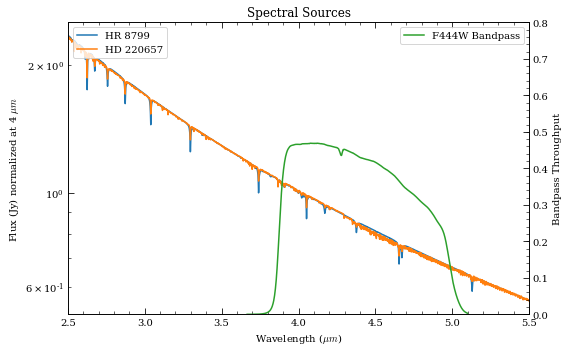

In [5]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    sp.convert('Jy')
    f = sp.flux / np.interp(4.0, w, sp.flux)
    ax.semilogy(w[ind], f[ind], lw=1.5, label=sp.name)
    ax.set_ylabel('Flux (Jy) normalized at 4 $\mu m$')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('Spectral Sources')

# Overplot Filter Bandpass
bp = pynrc.read_filter('F444W', 'CIRCLYOT', 'MASK430R')
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

## Initialize Observation

Now we will initialize the high-contrast imaging class `pynrc.obs_hci` using the spectral objects and various other settings. The `obs_hci` object is a subclass of the more generalized `NIRCam` class. It implements new settings and functions specific to high-contrast imaging observations for corongraphy and direct imaging.

For this tutorial, we want to observe these targets using the `MASK430R` coronagraph in the `F444W` filter. All circular coronagraphic masks such as the `430R` (R=round) should be paired with the `CIRCLYOT` pupil element, whereas wedge/bar masks are paired with `WEDGELYOT` pupil. Observations in the LW channel are most commonly observed in `WINDOW` mode with a 320x320 detector subarray size. Full detector sizes are also available.

The PSF simulation size (`fov_pix` keyword) should also be of similar size as the detector (recommend avoiding anything above `fov_pix=1024` due to computation time and memory usage). Use odd numbers to center the PSF in the middle of the pixel. If `fov_pix` is specified as even, then PSFs get centered at the corners. This distinction really only matter for unocculted observations, (ie., where the PSF flux is concentrated in a tight central core).

We also need to specify a WFE drift value (`wfe_ref_drift` parameter), which defines the anticipated drift in nm between the science and reference sources. For the moment, let's intialize with a value of 0nm. This prevents an initially long process by which `pynrc` calculates changes made to PSF over a wide range of drift values.

Extended disk models can also be specified upon initialization using the `disk_hdu` keyword.

In [6]:
filt, mask, pupil = ('F444W',  'MASK430R', 'CIRCLYOT')
wind_mode, subsize = ('WINDOW', 320)
fov_pix, oversample = (320, 2)

wfe_ref_drift = 0
obs = pynrc.obs_hci(sp_sci, sp_ref, dist_sci, filter=filt, mask=mask, pupil=pupil, 
                    wfe_ref_drift=wfe_ref_drift, fov_pix=fov_pix, oversample=oversample, 
                    wind_mode=wind_mode, xpix=subsize, ypix=subsize, verbose=True)

Generating background PSF coefficients...
Generating oversampled PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.


All information for the reference observation is stored in the attribute `obs.nrc_ref`, which is simply it's own isolated `NIRCam` class. After initialization, any updates made to the primary `obs` instrument configuration (e.g., filters, detector size, etc.) must also be made inside the `obs.nrc_ref` class as well. That is to say, it does not automatically propogate. In many ways, it's best to think of these as two separate classes,
```python
obs_sci = obs
obs_ref = obs.nrc_ref
```
with some linked references between the two.

Now that we've succesffully initialized the obs_hci observations, let's specify the `wfe_ref_drift`. If this is your first time, then the `nrc_utils.wfed_coeff` function is called to determine a relationship between PSFs in the presense of WFE drift. This relationship is saved to disk in the `PYNRC_DATA` directory as a set of polynomial coefficients. Future calculations utilize these coefficients to quickly generate a new PSF for any arbitary drift value.

In [7]:
# WFE drift amount between rolls
# This only gets called during gen_roll_image()
# and temporarily updates obs.wfe_drift to create
# a new PSF.
obs.wfe_roll_drift = 2

# Drift amount between Roll 1 and reference
# This is simply a link to obs.nrc_ref.wfe_drift
obs.wfe_ref_drift = 10

## Exposure Settings

Optimization of exposure settings are demonstrated in another tutorial, so we will not repeat that process here. We can assume that process was performed elsewhere to choose the `DEEP8` pattern with 16 groups and 5 total integrations. These settings apply to each roll position of the science observation as well as the for the reference observation.

In [8]:
# Update both the science and reference observations
obs.update_detectors(read_mode='DEEP8', ngroup=16, nint=5, verbose=True)
obs.nrc_ref.update_detectors(read_mode='DEEP8', ngroup=16, nint=5)

New Ramp Settings:
  read_mode :    DEEP8
  nf        :        8
  nd2       :       12
  ngroup    :       16
  nint      :        5
New Detector Settings
  wind_mode :   WINDOW
  xpix      :      320
  ypix      :      320
  x0        :      914
  y0        :     1513
New Ramp Times
  t_group   :   21.381
  t_frame   :    1.069
  t_int     :  329.264
  t_int_tot :  330.353
  t_exp     : 1646.322
  t_acq     : 1651.766


## Add Planets

There are four known giant planets orbiting HR 8799 at various locations. Ideally, we would like to position them at their predicted locations on the anticipated observation date. For this case, we choose a plausible observation date of November 1, 2019. To convert between $(x,y)$ and $(r,\theta)$, use the `nrc_utils.xy_to_rtheta` and `nrc_utils.rtheta_to_xy` functions.

When adding the planets, it doesn't matter too much which exoplanet model spectrum we decide to use since the spectra are still fairly unconstrained at these wavelengths. We do know roughly the planets' luminosities, so we can simply choose some reasonable model and renormalize it to the appropriate filter brightness. Currently, the only exoplanet spectral models available to `pynrc` are those from Spiegel & Burrows (2012).



In [9]:
# Projected locations for date 11/01/2019
# These are prelimary positions, but within constrained orbital parameters
loc_list = [(-1.57, 0.64), (0.42, 0.87), (0.5, -0.45), (0.35,  0.20)]

# Estimated magnitudes within F444W filter
pmags = [16.0, 15.0, 14.6, 14.7]

In [10]:
# Add planet information to observation class.
# These are stored in obs.planets.
# Can be cleared using obs.kill_planets().
obs.kill_planets()
for i, loc in enumerate(loc_list):
    obs.add_planet(mass=10, entropy=13, age=age, xy=loc, runits='arcsec', 
                   renorm_args=(pmags[i], 'vegamag', obs.bandpass))

In [11]:
# Generate and plot a noiseless slope image to make sure things look right
PA1 = 85
im_planets = obs.gen_planets_image(PA_offset=PA1)

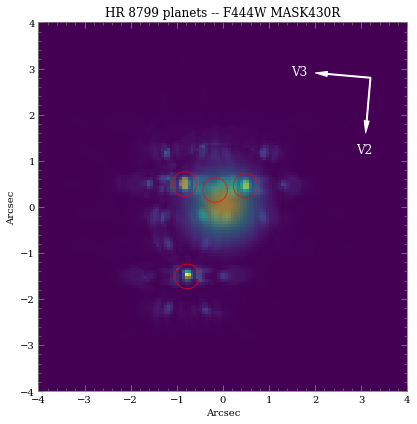

In [12]:
from matplotlib.patches import Circle
from pynrc.nrc_utils import (coron_ap_locs, build_mask_detid, fshift, pad_or_cut_to_size)

fig, ax = plt.subplots(figsize=(6,6))

xasec = obs.det_info['xpix'] * obs.pix_scale
yasec = obs.det_info['ypix'] * obs.pix_scale
extent = [-xasec/2, xasec/2, -yasec/2, yasec/2]
xylim = 4

vmin = 0
vmax = 0.5*im_planets.max()
ax.imshow(im_planets, extent=extent, vmin=vmin, vmax=vmax)

# Overlay the coronagraphic mask
detid = obs.Detectors[0].detid
im_mask = obs.mask_images[detid]
# Do some masked transparency overlays
masked = np.ma.masked_where(im_mask>0.99, im_mask)
ax.imshow(1-masked, extent=extent, alpha=0.5)
#ax.imshow(1-masked, extent=extent, alpha=0.3, cmap='Greys', vmin=-1)

xc_off = obs.bar_offset
for loc in loc_list:
    xc, yc = loc
    xc, yc = nrc_utils.xy_rot(xc, yc, PA1)
    xc += xc_off
    circle = Circle((xc,yc), radius=xylim/15., alpha=0.7, lw=1, edgecolor='red', facecolor='none')
    ax.add_artist(circle)

xlim = ylim = np.array([-1,1])*xylim
xlim = xlim + xc_off
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')

ax.set_title('{} planets -- {} {}'.format(sp_sci.name, obs.filter, obs.mask))

color = 'grey'
ax.tick_params(axis='both', color=color, which='both')
for k in ax.spines.keys():
    ax.spines[k].set_color(color)

nrc_utils.plotAxes(ax, width=1, headwidth=5, alength=0.15, angle=PA1, position=(0.9,0.85))
    
fig.tight_layout()

As we can see, even with "perfect PSF subtraction" and no noise, it's difficult to make out planet e. This is primarily due to its location relative to the occulting mask reducting throughput along with confusion of bright diffraction spots from nearby sources.

## Estimated Performance

Now we are ready to determine contrast performance and sensitivites as a function of distance from the star. 

### 1. Roll-Subtracted Images

First, we will create a quick simulated roll-subtracted image using the in `gen_roll_image` method. For the selected observation date of 11/1/2019, APT shows a PA range of 84$^{\circ}$ to 96$^{\circ}$. So, we'll assume Roll 1 has PA1=85, while Roll 2 has PA2=95. In this case, "roll subtraction" simply creates two science observations at two different parallactic angles and subtracts the same reference observation from each. The two results are then de-rotated to a common PA=0 and averaged.

There is also the option to create ADI images, where the other roll position becomes the reference star by setting `no_ref=True`. 

In [13]:
# Cycle through a few WFE drift values
wfe_list = [0,5,10]

# PA values for each roll
PA1, PA2 = (85, 95)

# A dictionary of HDULists
hdul_dict = {}
for i, wfe_drift in enumerate(wfe_list):
    print(wfe_drift)
    # Upate WFE reference drift value
    obs.wfe_ref_drift = wfe_drift
            
    # Set the final output image to be oversampled
    hdulist = obs.gen_roll_image(PA1=PA1, PA2=PA2)
    hdul_dict[wfe_drift] = hdulist


0
5
10


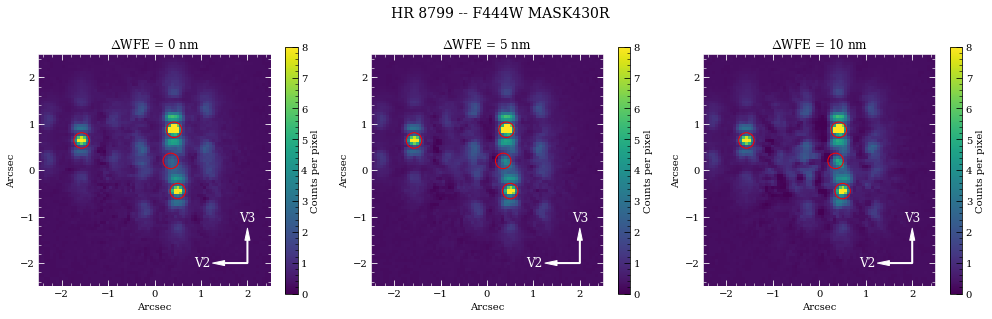

In [14]:
from pynrc.obs_nircam import plot_hdulist
from matplotlib.patches import Circle

fig, axes = plt.subplots(1,3, figsize=(14,4.3))
xylim = 2.5
xlim = ylim = np.array([-1,1])*xylim

for j, wfe_drift in enumerate(wfe_list):
    ax = axes[j]
    hdul = hdul_dict[wfe_drift]
    
    plot_hdulist(hdul, xr=xlim, yr=ylim, ax=ax, vmin=0, vmax=8)

    # Location of planet
    for loc in loc_list:
        circle = Circle(loc, radius=xylim/15., lw=1, edgecolor='red', facecolor='none')
        ax.add_artist(circle)

    ax.set_title('$\Delta$WFE = {:.0f} nm'.format(wfe_drift))
    
    nrc_utils.plotAxes(ax, width=1, headwidth=5, alength=0.15)

fig.suptitle('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

**Note:** At first glance, it appears as if Planet e is getting brighter with increased WFE drift, which would be understandably confusing. However, upon further investigation, there just happens to be a bright residual speckle that lines up well with Planet e when observed at this specific parallactic angle. This was verified by adjusting the observed PA as well as completing removing the planets from the simulations.

### 2. Contrast Curves

Next, we will cycle through a few WFE drift values to get an idea of potential predicted sensitivity curves. The `calc_contrast` method returns a tuple of three arrays:
1. The radius in arcsec.
2. The n-sigma contrast.
3. The n-sigma magnitude sensitivity limit (vega mag).

In [15]:
# Cycle through varying levels of WFE drift and calculate contrasts
wfe_list = [0,5,10]
nsig = 5

# PA values for each roll
PA1, PA2 = (85, 95)
roll_angle = np.abs(PA2 - PA1)

curves = []
for i, wfe_drift in enumerate(wfe_list):
    print(wfe_drift)
    # Generate series of observations for each filter
    obs.wfe_ref_drift = wfe_drift
            
    # Generate contrast curves
    result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig)
    curves.append(result)


0
5
10


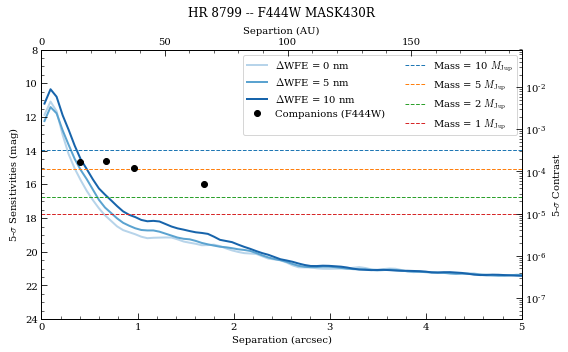

In [16]:
from pynrc.obs_nircam import plot_contrasts, plot_planet_patches

fig, ax = plt.subplots(figsize=(8,5))
xr=[0,5]
yr=[24,8]

# Plot contrast curves and set x/y limits
ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs, 
                              xr=xr, yr=yr, ax=ax, return_axes=True)

# Plot the locations of exoplanet companions
label = 'Companions ({})'.format(filt)
planet_dist = [np.sqrt(x**2+y**2) for x,y in loc_list]
ax.plot(planet_dist, pmags, marker='o', ls='None', label=label, color='k', zorder=10)    

# Plot Spiegel & Burrows (2012) exoplanet fluxes (Hot Start)
plot_planet_patches(ax, obs, age=age, entropy=13, av_vals=None)

ax.legend(ncol=2)
ax.set_title('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), y=1.1)

fig.tight_layout()

### 3. Saturation Levels

Create an image showing level of saturation for each pixel. For NIRCam, saturation is important to track for purposes of accurate slope fits and persistence correction. In this case, we will plot the saturation levels both at `NGROUP=2` and `NGROUP=obs.det_info['ngroup']`. Saturation is defined at 80% well level.

We want to perform this analysis for both science and reference targets.

In [17]:
# Saturation limits
ng_max = obs.det_info['ngroup']
sp_flat = pynrc.stellar_spectrum('flat')

print('NGROUP=2')
_ = obs.sat_limits(sp=sp_flat,ngroup=2,verbose=True)

print('')
print('NGROUP={}'.format(ng_max))
_ = obs.sat_limits(sp=sp_flat,ngroup=ng_max,verbose=True)

mag_sci = obs.star_flux('vegamag')
mag_ref = obs.star_flux('vegamag', sp=obs.sp_ref)
print('')
print('{} flux at {}: {:0.2f} mags'.format(obs.sp_sci.name, obs.filter, mag_sci))
print('{} flux at {}: {:0.2f} mags'.format(obs.sp_ref.name, obs.filter, mag_ref))

NGROUP=2
F444W Saturation Limit assuming Flat spectrum in photlam source: 2.40 vegamag

NGROUP=16
F444W Saturation Limit assuming Flat spectrum in photlam source: 5.00 vegamag

HR 8799 flux at F444W: 5.24 mags
HD 220657 flux at F444W: 3.03 mags


In this case, we don't expect HR 8799 to saturated. However, the reference source should have some saturated pixels before the end of an integration. 

In [18]:
# Well level of each pixel for science source
sci_levels1 = obs.saturation_levels(ngroup=2)
sci_levels2 = obs.saturation_levels(ngroup=ng_max)

# Which pixels are saturated?
sci_mask1 = sci_levels1 > 0.8
sci_mask2 = sci_levels2 > 0.8

In [19]:
# Well level of each pixel for reference source
ref_levels1 = obs.saturation_levels(ngroup=2, do_ref=True)
ref_levels2 = obs.saturation_levels(ngroup=ng_max, do_ref=True)

# Which pixels are saturated?
ref_mask1 = ref_levels1 > 0.8
ref_mask2 = ref_levels2 > 0.8

In [20]:
# How many saturated pixels?
nsat1_sci = len(sci_levels1[sci_mask1])
nsat2_sci = len(sci_levels2[sci_mask2])

print(obs.sp_sci.name)
print('{} saturated pixel at NGROUP=2'.format(nsat1_sci))
print('{} saturated pixel at NGROUP={}'.format(nsat2_sci,ng_max))

# How many saturated pixels?
nsat1_ref = len(ref_levels1[ref_mask1])
nsat2_ref = len(ref_levels2[ref_mask2])

print('')
print(obs.sp_ref.name)
print('{} saturated pixel at NGROUP=2'.format(nsat1_ref))
print('{} saturated pixel at NGROUP={}'.format(nsat2_ref,ng_max))

HR 8799
0 saturated pixel at NGROUP=2
0 saturated pixel at NGROUP=16

HD 220657
0 saturated pixel at NGROUP=2
721 saturated pixel at NGROUP=16


In [21]:
nsat1, nsat2 = (nsat1_sci, nsat2_sci)
sat_mask1, sat_mask2 = (sci_mask1, sci_mask2)
sp = obs.sp_sci
nrc = obs

# Only display saturation masks if there are saturated pixels
if nsat2 > 0:
    fig, axes = plt.subplots(1,2, figsize=(10,5))

    xasec = nrc.det_info['xpix'] * nrc.pix_scale
    yasec = nrc.det_info['ypix'] * nrc.pix_scale
    extent = [-xasec/2, xasec/2, -yasec/2, yasec/2]

    axes[0].imshow(sat_mask1, extent=extent)
    axes[1].imshow(sat_mask2, extent=extent)

    axes[0].set_title('{} Saturation (NGROUP=2)'.format(sp.name))
    axes[1].set_title('{} Saturation (NGROUP={})'.format(sp.name,ng_max))

    for ax in axes:
        ax.set_xlabel('Arcsec')
        ax.set_ylabel('Arcsec')
        
        ax.tick_params(axis='both', color='white', which='both')
        for k in ax.spines.keys():
            ax.spines[k].set_color('white')

    fig.tight_layout()
else:
    print('No saturation detected.')

No saturation detected.


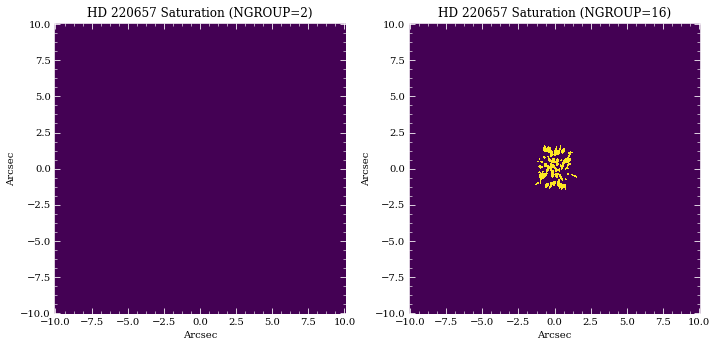

In [22]:
nsat1, nsat2 = (nsat1_ref, nsat2_ref)
sat_mask1, sat_mask2 = (ref_mask1, ref_mask2)
sp = obs.sp_ref
nrc = obs.nrc_ref

# Only display saturation masks if there are saturated pixels
if nsat2 > 0:
    fig, axes = plt.subplots(1,2, figsize=(10,5))

    xasec = nrc.det_info['xpix'] * nrc.pix_scale
    yasec = nrc.det_info['ypix'] * nrc.pix_scale
    extent = [-xasec/2, xasec/2, -yasec/2, yasec/2]

    axes[0].imshow(sat_mask1, extent=extent)
    axes[1].imshow(sat_mask2, extent=extent)

    axes[0].set_title('{} Saturation (NGROUP=2)'.format(sp.name))
    axes[1].set_title('{} Saturation (NGROUP={})'.format(sp.name,ng_max))

    for ax in axes:
        ax.set_xlabel('Arcsec')
        ax.set_ylabel('Arcsec')
        
        ax.tick_params(axis='both', color='white', which='both')
        for k in ax.spines.keys():
            ax.spines[k].set_color('white')

    fig.tight_layout()
else:
    print('No saturation detected.')